## Modelo de Machine Learning: Similitud del Coseno
Para desarrollar nuestro sistema de recomendaciones, utilizaremos las columnas *“developer”, “genre” y “specs”*, creando una nueva columna llamada *combined_features*.
En esta etapa, normalizaremos el texto eliminando palabras vacías (stop words) en inglés y símbolos innecesarios, dejando solo letras para un análisis más preciso.
### *Se basa en dos conceptos fundamentales*: ###
-**Frecuencia de Término (TF):** Mide cuántas veces aparece una palabra en un documento en relación con el total de palabras. Las palabras más frecuentes son consideradas más relevantes.
-**Frecuencia Inversa de Documento (IDF):** Evalúa la importancia de una palabra en todo el conjunto de documentos. Palabras comunes tienen un IDF bajo, mientras que palabras raras tienen un IDF alto.  Estos conceptos nos permitirán calcular similitudes y ofrecer recomendaciones personalizadas a los jugadores.

In [14]:
# 1. Importar las librerias necesarias y cargar el dataset 
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

games= pd.read_parquet(r"C:\Users\veram\OneDrive\Escritorio\proyecto octubre\Datos_parquet\data_games.parquet")
df_games = games


In [19]:
df_games

,id,title,developer,specs,price,release_year,is_free,genre,combined_features
0,761140,Lost Summoner Kitty,Kotoshiro,Single-player,4.99,2018,False,"Action, Casual",kotoshiro action casual singleplayer
1,643980,Ironbound,Secret Level SRL,Single-player,0.00,2018,True,"Indie, RPG",secret level srl indie rpg singleplayer
2,670290,Real Pool 3D - Poolians,Poolians.com,Single-player,0.00,2017,True,"Casual, Indie",poolianscom casual indie singleplayer
3,767400,弹炸人2222,彼岸领域,Single-player,0.99,2017,False,"Action, Adventure",action adventure singleplayer
4,772540,Battle Royale Trainer,Trickjump Games Ltd,Single-player,3.99,2018,False,"Action, Adventure",trickjump games ltd action adventure singleplayer
...,...,...,...,...,...,...,...,...,...
27138,745400,Kebab it Up!,Bidoniera Games,Single-player,1.99,2018,False,"Action, Adventure",bidoniera games action adventure singleplayer
27139,773640,Colony On Mars,"Nikita ""Ghost_RUS""",Single-player,1.99,2018,False,"Casual, Indie",nikita ghostrus casual indie singleplayer
27140,733530,LOGistICAL: South Africa,Sacada,Single-player,4.99,2018,False,"Casual, Indie",sacada casual indie singleplayer
27141,610660,Russian Roads,Laush Dmitriy Sergeevich,Single-player,1.99,2018,False,"Indie, Racing",laush dmitriy sergeevich indie racing singlepl...


In [17]:
# 2. indagaremos en la distribución de géneros, desarrolladores y aspectos dentro del dataset 
print(df_games['genre'].value_counts())
print(df_games['developer'].value_counts())
print(df_games['specs'].isnull().sum())


genre
Action, Adventure           3657
Action, Indie               2927
Casual, Indie               2161
Action                      1861
Adventure, Indie            1733
                            ... 
Photo Editing, Utilities       1
Early Access, Indie            1
Sports, Simulation             1
Sports, Casual                 1
Strategy, Action               1
Name: count, Length: 101, dtype: int64
developer
Ubisoft - San Francisco                  1258
SmiteWorks USA, LLC                       812
Dovetail Games                            253
KOEI TECMO GAMES CO., LTD.                214
Paradox Development Studio                153
                                         ... 
Mark Healey                                 1
SyKoHPaTh                                   1
Patrick Hofmann                             1
DreamInCode B.V.,Squadron Interactive       1
彼岸领域                                        1
Name: count, Length: 10500, dtype: int64
0


In [20]:
# 3. Crearemos la Función para normalizar texto y la aplicaremos a nuestra data
def normalize_text(text):
     
     # Pasar a minúsculas
    text = text.lower().strip()
    text = re.sub(r'[^a-z\s]', '', text)  # Eliminar símbolos y signos
    
    return text

# 4. Crearemos una  nueva columna llamada 'combined_features'
df_games['combined_features'] = (
    df_games['developer'].apply(normalize_text) + ' ' +
    df_games['genre'].apply(normalize_text) + ' ' +
    df_games['specs'].apply(normalize_text)
)

print(df_games['combined_features'].head())



0                 kotoshiro action casual singleplayer
1              secret level srl indie rpg singleplayer
2                poolianscom casual indie singleplayer
3                        action adventure singleplayer
4    trickjump games ltd action adventure singleplayer
Name: combined_features, dtype: object


In [21]:

# 5. Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=0.01, max_df=0.95)

# 6. Aplicar el vectorizador a la columna combinada
tfidf_matrix = vectorizer.fit_transform(df_games['combined_features'])

# 7. Calcular la matriz de similitud del coseno
cosine_sim = cosine_similarity(tfidf_matrix)



'''
# 7.1 de ser necesario guardar el resultado:

-Guardar la matriz de similitud
joblib.dump(cosine_sim, 'cosine_sim.joblib')

-Guardar el vectorizador para usarlo más adelante
joblib.dump(vectorizer, 'vectorizer.joblib')


'''


"\n# 7.1 de ser necesario guardar el resultado:\n\n-Guardar la matriz de similitud\njoblib.dump(cosine_sim, 'cosine_sim.joblib')\n\n-Guardar el vectorizador para usarlo más adelante\njoblib.dump(vectorizer, 'vectorizer.joblib')\n\n\n"

### Función de Recomendaciones
Hemos desarrollado una función que genera recomendaciones basadas en los datos procesados anteriormente.
-**Transformación**: Convierte el título del videojuego a minúsculas y elimina espacios en blanco.
-**Búsqueda**: Localiza el índice del videojuego en el DataFrame df_games donde el título coincide.
-**Verificación**: Si se encuentra el índice, se devuelve; de lo contrario, se lanza una excepción.
Esta función permite acceder de manera eficiente a las recomendaciones más relevantes para los usuarios.

In [22]:
#8 . creamos la función: 

def get_index_from_title(game_title, df_games):
    
    game_title = game_title.lower().strip()
    
    # 8.1Buscamos el índice del juego cuyo título coincide con game_title
    indices = df_games[df_games['title'].str.lower().str.contains(game_title, na=False)].index
  
    #8.2 Verificamos si hay coincidencias
    if not indices.empty:
        return indices[0]
    raise ValueError("Título no encontrado")


### Descripción del Proceso de Recomendación
-**Obtención de Índice**: Se invoca la función get_index_from_title para localizar el índice del videojuego solicitado.
-**Cálculo de Similitud**: Se calcula la similitud del coseno entre el videojuego elegido y los demás.
-**Ordenación**: Los videojuegos se ordenan según su puntuación de similitud.
-**Selección de Resultados**: Se extraen y devuelven los nombres de los 5 videojuegos más similares.

In [23]:
# 9. Función  de recomendación:

def get_recommendations(game_title, df_games):

    try:
        # 9.1 Obtenemos el índice del videojuego buscado por título
        idx = get_index_from_title(game_title, df_games)
        
        # 9.2Calculamos la similitud del coseno
        cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
        
        # 9.3Enumeramos los videojuegos y se ordenan por su similitud
        sim_scores = list(enumerate(cosine_sim[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # 9.4 Obtenemos los índices de los 5 videojuegos más similares
        game_indices = [i[0] for i in sim_scores[1:6]]
        
        # 9.5 Devolvemos los nombres de los videojuegos recomendados
        return df_games['title'].iloc[game_indices].tolist()
   
    except ValueError:
        return ["No se encontró el videojuego en los datos"]


### Ejemplo de Uso
Al utilizar la función get_recommendations, asegúrate de que el tfidf_matrix ya esté calculado. A continuación se presenta un ejemplo de cómo implementarlo:

In [24]:
# 10.Llamada a la función con el título deseado
resultados_recomendaciones = get_recommendations("Lew Pulsipher's Doomstar", df_games)
print("Recomendaciones:", resultados_recomendaciones)


Recomendaciones: ['Vegas: Make It Big™', 'Railroad Tycoon 3', 'Railroad Tycoon II Platinum', 'Genesis Rising', 'Rome: Total War™ - Collection']


### Gráfica
Al ejecutar el sistema, es posible que las recomendaciones para **Lew Pulsipher's Doomstar** incluyan títulos que han demostrado ser populares o relevantes en la misma categoría, enriqueciendo la experiencia del jugador y facilitando el descubrimiento de nuevos juegos.

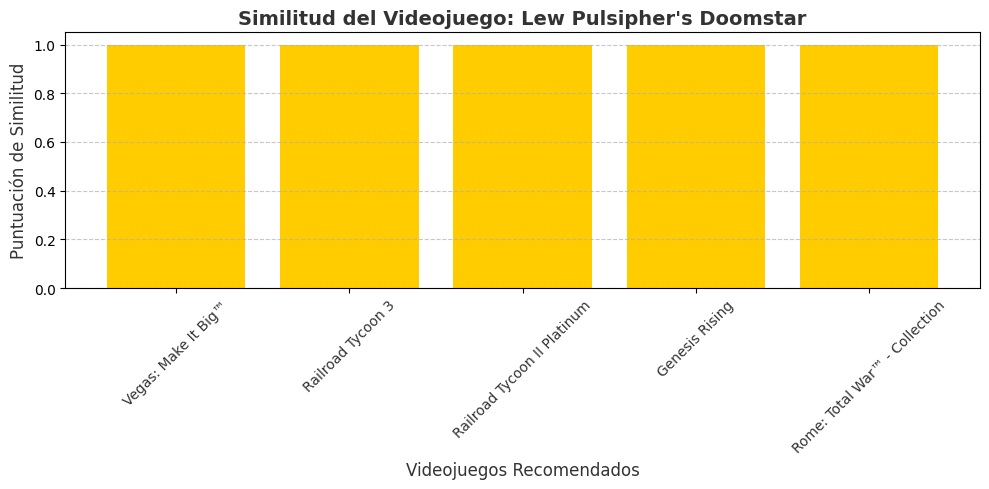

In [25]:
game_title = "Lew Pulsipher's Doomstar"

# 11.1 Obtener recomendaciones
recomendaciones = get_recommendations(game_title, df_games)

# 11.2 Obtener la similitud para el gráfico
idx = get_index_from_title(game_title, df_games)
cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
sim_scores = list(enumerate(cosine_sim[0]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
top_similarities = sim_scores[1:6]  # Top 5

# 11.3 Crear DataFrame para el gráfico
df_similarities = pd.DataFrame(top_similarities, columns=['Index', 'Similarity'])
df_similarities['Game'] = df_games['title'].iloc[df_similarities['Index']].values

# 11.4 Gráfico de barras con estilo
plt.figure(figsize=(10, 5))
plt.bar(df_similarities['Game'], df_similarities['Similarity'], color='#FFCC00')  # Color amarillo
plt.title('Similitud del Videojuego: ' + game_title, fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('Videojuegos Recomendados', fontsize=12, color='#333333')
plt.ylabel('Puntuación de Similitud', fontsize=12, color='#333333')
plt.xticks(rotation=45, fontsize=10, color='#333333')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una cuadrícula ligera en el eje y
plt.tight_layout()  # Ajustar el layout para evitar solapamientos
plt.show()